# STL Model Creation

Clayton Miller - miller.clayton@gmail.com

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import timeit
import os
from datetime import datetime
from __future__ import division
import matplotlib.dates as mdates
from matplotlib import ticker
import datetime
import matplotlib

In [2]:
import rpy2

In [3]:
sns.set_style("whitegrid")

In [4]:
%matplotlib inline

In [5]:
%load_ext rpy2.ipython 

In [6]:
from pylab import *

In [7]:
repos_path = "/Users/Clayton/temporal-features-for-buildings/"

In [8]:
meta = pd.read_csv(os.path.join(repos_path,"data/raw/meta_open.csv"), index_col='uid', parse_dates=["datastart","dataend"], dayfirst=True)

In [9]:
temp = pd.read_csv((os.path.join(repos_path,"data/interim/temp_open_utc_complete.csv")), index_col='timestamp', parse_dates=True).tz_localize('utc')

# One building STL model

In [10]:
%%R 
library(forecast)
library(stats)

/Users/Clayton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: zoo

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/Clayton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘zoo’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/Clayton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/Clayton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: timeDate

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/Clayton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: This is forecast 6.1 


  res = super(Function, self).__call__(*new_args, **ne

In [11]:
building = "PrimClass_Everett"

In [12]:
timezone = meta.T[building].timezone
start = meta.T[building].datastart
end = meta.T[building].dataend
building_data = temp[building].tz_convert(timezone).truncate(before=start,after=end).resample('D').sum()
data = building_data.reset_index(drop=True)
    

In [13]:
year = start.year
month = start.month
day = start.day

In [14]:
%Rpush data
%Rpush year
%Rpush month
%Rpush day


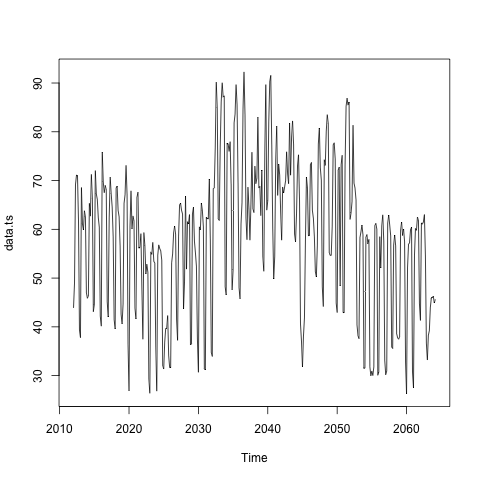

In [15]:
%R df <- as.numeric(data)
%R data <- unname(df, force = FALSE)
%R data.ts <- ts(data, start=c(year,month,day), freq=7)
%R plot(data.ts)

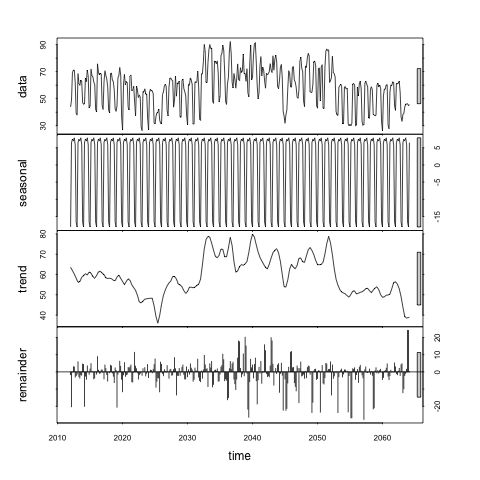

In [16]:
%R data.stl <- stl(data.ts, s.window="periodic", robust=TRUE)
%R plot(data.stl)

In [17]:
%R remainder <- data.stl$time.series[,"remainder"]
%R trend <- data.stl$time.series[,"trend"]
%R seasonal <- data.stl$time.series[,"seasonal"]

%Rpull remainder
%Rpull trend
%Rpull seasonal

In [18]:
remainder = pd.DataFrame({building:remainder}, index=building_data.index).tz_localize(None)
trend = pd.DataFrame({building:trend}, index=building_data.index).tz_localize(None)
seasonal = pd.DataFrame({building:seasonal}, index=building_data.index).tz_localize(None)

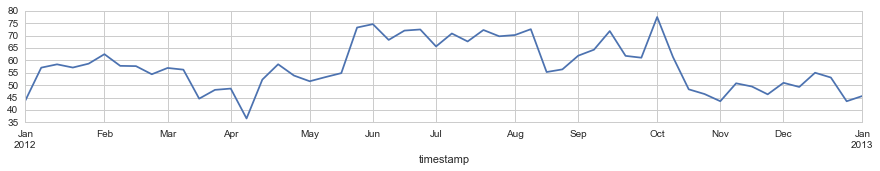

In [19]:
building_data.resample("W").mean().plot(figsize=(15,2));

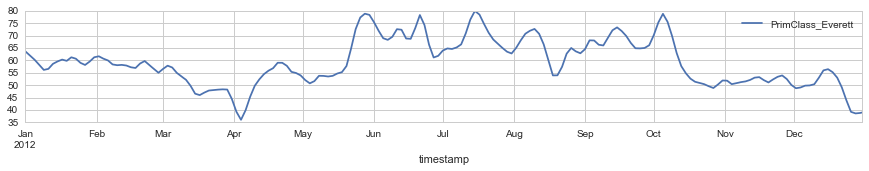

In [20]:
trend.plot(figsize=(15,2));

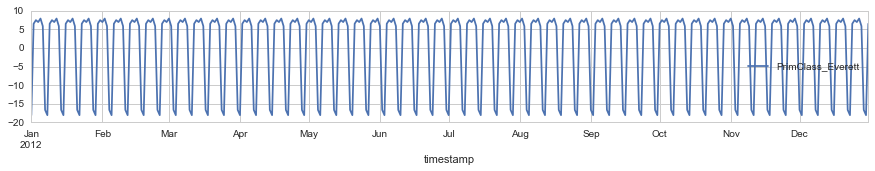

In [21]:
seasonal.plot(figsize=(15,2));

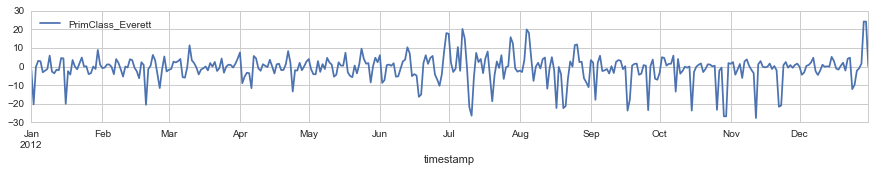

In [22]:
remainder.plot(figsize=(15,2));

In [23]:
def decompose_building(temp, meta, building):
    
    timezone = meta.T[building].timezone
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    building_data = temp[building].tz_convert(timezone).truncate(before=start,after=end).resample('D').sum()
    data = building_data.reset_index(drop=True)

    year = start.year
    month = start.month
    day = start.day

    %Rpush data
    %Rpush year
    %Rpush month
    %Rpush day

    %R df <- as.numeric(data)
    %R data <- unname(df, force = FALSE)
    %R data.ts <- ts(data, start=c(year,month,day), freq=7)
    %R data.stl <- stl(data.ts, s.window="periodic", robust=TRUE)

    %R remainder <- data.stl$time.series[,"remainder"]
    %R trend <- data.stl$time.series[,"trend"]
    %R seasonal <- data.stl$time.series[,"seasonal"]

    %Rpull remainder
    %Rpull trend
    %Rpull seasonal
    
    remainder_df = pd.DataFrame({building:remainder}, index=building_data.index).tz_localize(None)
    trend_df = pd.DataFrame({building:trend}, index=building_data.index).tz_localize(None)
    seasonal_df = pd.DataFrame({building:seasonal}, index=building_data.index).tz_localize(None)
    
    remainder_df = remainder_df/np.abs(building_data).max()
    trend_df = (trend_df - trend.min())/(trend_df.max()-trend.min())

    return remainder_df, trend_df, seasonal_df

In [24]:
meta.head()

,dataend,datastart,energystarscore,heatingtype,industry,mainheatingtype,numberoffloors,occupants,primaryspaceusage,rating,sqft,sqm,subindustry,timezone,yearbuilt,nickname,primaryspaceuse_abbrev,newweatherfilename
uid,,,,,,,,,,,,,,,,,,
PrimClass_Everett,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Education,NaN,NaN,NaN,Primary/Secondary Classroom,NaN,105530.0,9804.053590,Primary/Secondary School,America/New_York,NaN,Everett,PrimClass,weather12.csv
UnivClass_Clifford,2015-12-31 23:00:00,2015-01-01,NaN,NaN,Education,NaN,NaN,NaN,College Classroom,NaN,56969.0,5292.591007,College/University,America/New_York,1967,Clifford,UnivClass,weather2.csv
Office_Elizabeth,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Commercial Property,NaN,NaN,NaN,Office,NaN,294651.0,27373.961850,Commercial Real Estate,America/Los_Angeles,NaN,Elizabeth,Office,weather22.csv
Office_Ellie,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Commercial Property,NaN,NaN,NaN,Office,NaN,496517.0,46127.918850,Bank/Financial Services,America/Los_Angeles,NaN,Ellie,Office,weather28.csv
PrimClass_Elisabeth,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Education,NaN,NaN,NaN,Primary/Secondary Classroom,NaN,233062.0,21652.158990,Primary/Secondary School,America/New_York,NaN,Elisabeth,PrimClass,weather23.csv


In [25]:
building = "PrimClass_Everett"

In [26]:
remainder, trend, seasonal = decompose_building(temp, meta, building)

In [27]:
remainder.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2012-01-01 to 2012-12-31
Freq: D
Data columns (total 1 columns):
PrimClass_Everett    366 non-null float64
dtypes: float64(1)
memory usage: 5.7 KB


In [28]:
def get_individual_data(temp, meta, building):
    timezone = meta.T[building].timezone
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    return pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))

def get_individual_data_notz(temp, meta, building):
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    return pd.DataFrame(temp[building].truncate(before=start,after=end))

In [29]:
def plot_line_example(df_1, df_2, color, vartitle):
    sns.set(rc={"figure.figsize": (12,4)})
    sns.set_style('whitegrid')
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    df_1.columns = ["Actual kWh"]
    #df_predicted.columns = ["Predicted kWh"]
    ax1 = fig.add_subplot(gs[1:60,:])
    df_1.plot(ax = ax1, legend=False) # .resample("D").sum()
    ax1.xaxis.set_visible(False)
    ax1.set_title("Hourly kWh")
    
    ax2 = fig.add_subplot(gs[68:,:])
    #df_2 = df_2.tz_localize(None)
    x = mdates.drange(df_2.index[0], df_2.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df_2.columns), len(df_2.columns)+1)
    data = np.array(df_2.T)
    datam = np.ma.array(data, mask=np.isnan(data))
    cmap = matplotlib.cm.get_cmap(color)
    
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap)
    ax2.set_title(vartitle)
    
    #leftspacing, 
    cbaxes = fig.add_axes([0.18, 0.08, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax2, orientation='horizontal', cax=cbaxes)
    tick_locator = ticker.MaxNLocator(nbins=7)
    cbar.locator = tick_locator
    cbar.update_ticks()
    
    ax2.axis('tight')
    ax2.xaxis_date()
    ax2.yaxis.set_visible(False)
    myFmt = mdates.DateFormatter('%b')
    ax2.xaxis.set_major_formatter(myFmt)

In [30]:
# start = '2015-07-01'
# end = '2015-09-30'

In [31]:
remainder.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2012-01-01 to 2012-12-31
Freq: D
Data columns (total 1 columns):
PrimClass_Everett    366 non-null float64
dtypes: float64(1)
memory usage: 5.7 KB


In [32]:
df = get_individual_data(temp, meta, building)
#df = df.truncate(before=start,after=end)#
#breakout = breakout#.truncate(before=start,after=end)

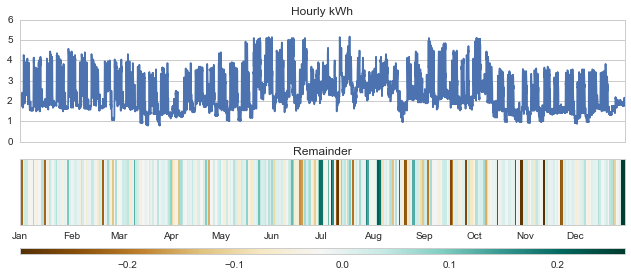

In [33]:
plot_line_example(df, remainder, "BrBG","Remainder")
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/stl_remainder_example.png"));

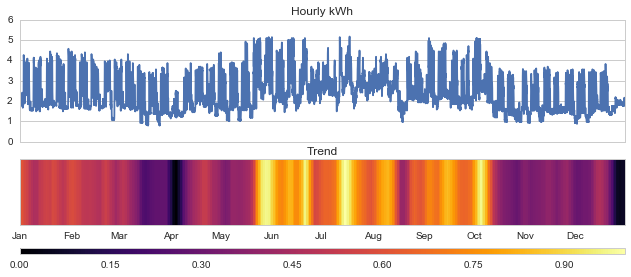

In [34]:
plot_line_example(df, trend, "inferno","Trend")
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/stl_trend_example.png"));

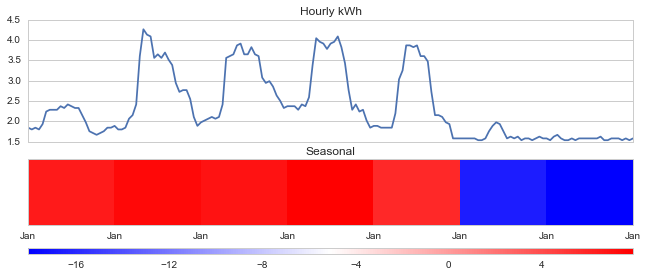

In [35]:
plot_line_example(df.truncate(before='2012-01-02',after='2012-01-09'), seasonal.truncate(before='2012-01-02',after='2012-01-09'), "bwr","Seasonal")
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/stl_seasonal_example.png"));

# Loop though all buildings

In [36]:
overall_start_time = timeit.default_timer()

temp_remainder = pd.DataFrame()
temp_trend = pd.DataFrame()
temp_seasonal = pd.DataFrame()

for building in meta.index:
    remainder, trend, seasonal = decompose_building(temp, meta, building)
    temp_remainder = pd.merge(temp_remainder, remainder, right_index=True, left_index=True, how='outer')
    temp_trend = pd.merge(temp_trend, trend, right_index=True, left_index=True, how='outer')
    temp_seasonal = pd.merge(temp_seasonal, seasonal, right_index=True, left_index=True, how='outer')
    
print "Calculated all building in "+str(timeit.default_timer() - overall_start_time)+" seconds"


Calculated all building in 65.3459711075 seconds


In [37]:
temp_trend.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1706 entries, 2010-01-01 to 2015-12-31
Columns: 507 entries, PrimClass_Everett to UnivLab_Aoife
dtypes: float64(507)
memory usage: 6.6 MB


# Overview heatmap

In [18]:
temp_trend = pd.read_csv(os.path.join(repos_path,"data/interim/temp_stl_trend.csv"), index_col='timestamp', parse_dates=True)
temp_remainder = pd.read_csv(os.path.join(repos_path,"data/interim/temp_stl_remainder.csv"), index_col='timestamp', parse_dates=True)
temp_seasonal = pd.read_csv(os.path.join(repos_path,"data/processed/features_stl_weeklypattern.csv"), index_col='timestamp', parse_dates=True)

In [19]:
temp_seasonal

,PrimClass_Everett,UnivClass_Clifford,Office_Elizabeth,Office_Ellie,PrimClass_Elisabeth,Office_Cristina,PrimClass_Jolie,PrimClass_Jaylin,Office_Jesus,PrimClass_Esmeralda,...,Office_Pauline,UnivLab_Dianna,UnivDorm_Cecilia,Office_Luann,Office_Milton,Office_Lane,Office_Cameron,UnivLab_Lea,UnivLab_Carlos,UnivLab_Aoife
timestamp,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,500.285106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-808.398818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1095.974813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-24.155884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,464.261907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,490.373920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,473.608572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,500.285106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-808.398818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# def heatmap_data(df):
#     x = np.linspace(0, len(df.index), len(df.index)+1)
#     y = np.linspace(0, len(df.columns), len(df.columns)+1)
#     return x,y

def heatmap_data(df):
    x = mdates.drange(df.index[0], df.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    return x,y

#This function changes the year for all of the buildings so that they can be overlapped for plotting
# THE RESULTING DATAFRAME IS ONLY FOR "GENERALIZED" PLOTTING TO GET THE DATA SETS TO OVERLAP -- DON'T PERFORM CALCULATIONS ON IT

def changeto2015(x):
    try:
        return x.replace(year=2015)
    except:
        return np.nan
    
def is_leap_and_29Feb(s):
    return (s.index.year % 4 == 0) & ((s.index.year % 100 != 0) | (s.index.year % 400 == 0)) & (s.index.month == 2) & (s.index.day == 29)

def generalize_timestamp_forplotting(meta, temp):
    temp_generalized = pd.DataFrame()
    buildinglist = list(meta.index)
    
    for building in buildinglist:
        #Change to timezone
        timezone = meta.T[building].timezone
        start = meta.T[building].datastart
        end = meta.T[building].dataend
        building_data = pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))
        
        #Remove leap year day for 2012
        mask = is_leap_and_29Feb(building_data)
        building_data = building_data.loc[~mask]
        
        #Change to 2015 -- we arbitrarily use this year
        building_data.index = building_data.index.map(lambda t: changeto2015(t))
        
        #Remove tz awareness, resample to normalize the timestamps and ffill to get rid of the gaps
        building_data = building_data.tz_localize(None)
        building_data = building_data.resample('D').mean().sort_index()
        building_data = building_data.ffill()
        
        #Merge into dataset
        temp_generalized = pd.merge(temp_generalized, building_data, right_index=True, left_index=True, how='outer')
        temp_generalized = temp_generalized.resample('D').mean().sort_index()
        
        #print "finished building: "+building
    return temp_generalized

def generalize_timestamp_forplotting_notz(meta, temp):
    temp_generalized = pd.DataFrame()
    buildinglist = list(meta.index)
    
    for building in buildinglist:
        #Change to timezone
        start = meta.T[building].datastart
        end = meta.T[building].dataend
        building_data = pd.DataFrame(temp[building].truncate(before=start,after=end))
        
        #Remove leap year day for 2012
        mask = is_leap_and_29Feb(building_data)
        building_data = building_data.loc[~mask]
        
        #Change to 2015 -- we arbitrarily use this year
        building_data.index = building_data.index.map(lambda t: changeto2015(t))
        
        #Remove tz awareness, resample to normalize the timestamps and ffill to get rid of the gaps
        building_data = building_data.tz_localize(None)
        building_data = building_data.resample('D').mean().sort_index()
        building_data = building_data.ffill()
        
        #Merge into dataset
        temp_generalized = pd.merge(temp_generalized, building_data, right_index=True, left_index=True, how='outer')
        temp_generalized = temp_generalized.resample('D').mean().sort_index()
        
        #print "finished building: "+building
    return temp_generalized

def plotmap(df, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel):
    
    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (5,11)})
    sns.set_style("whitegrid")
    
    numberofplots = 1
    fig = plt.figure()
    
    x = mdates.drange(df.index[0], df.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    ax = fig.add_subplot(numberofplots, 1, 1)
    data = np.array(df.T)
    datam = np.ma.array(data, mask=np.isnan(data))
    cmap = matplotlib.cm.get_cmap(color)
    qmesh = ax.pcolormesh(x, y, datam, cmap=cmap)
    
    cbaxes = fig.add_axes([0.15, 0.15, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax, orientation='horizontal', cax=cbaxes)
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)
    
    ax.axis('tight')
    ax.xaxis_date()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    ax.set_xlabel(xaxislabel)
    ax.set_ylabel(yaxislabel)
    ax.set_title(graphiclabel)
    
    ax.set_yticklabels(df.columns)
    tick_locator = ticker.MaxNLocator(nbins=110)
    loc = ticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    ax.locator_params(axis='y', nbins=100)
    myFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_formatter(myFmt)
    
    plt.subplots_adjust(bottom=0.2)

def plotmap_subplots(df, meta, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel, z_min, z_max):

    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (5,11)})
    sns.set_style("whitegrid")
    cmap = matplotlib.cm.get_cmap(color)
    
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    # Plot Offices
    df_office = df[df.columns[df.columns.str.contains("Office")]]
    office_height = int(len(df_office.T)/len(df.T)*100-2)
    ax1 = fig.add_subplot(gs[1:office_height,:])
    x,y = heatmap_data(df_office)
    data = np.array(df_office.T)
    datam = np.ma.array(data, mask=np.isnan(df_office))
    qmesh = ax1.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax1.axis('tight')
    #ax1.xaxis_date()
    #ax1.set_title("Offices")
    ax1.xaxis.set_visible(False)
    
    # Plot UnivLab
    df_lab = df[df.columns[df.columns.str.contains("UnivLab")]]
    lab_height = int(len(df_lab.T)/len(df.T)*100-2)
    ax2 = fig.add_subplot(gs[office_height+2:office_height+lab_height,:])
    x,y = heatmap_data(df_lab)
    data = np.array(df_lab.T)
    datam = np.ma.array(data, mask=np.isnan(df_lab))
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax2.axis('tight')
    #ax2.xaxis_date()
    #ax2.set_title("University Labs")
    ax2.xaxis.set_visible(False)
    
    # Plot UnivClass
    df_uniclass = df[df.columns[df.columns.str.contains("UnivClass")]]
    uniclass_height = int(len(df_uniclass.T)/len(df.T)*100-2)
    ax3 = fig.add_subplot(gs[office_height+lab_height+2:office_height+lab_height+uniclass_height,:])
    x,y = heatmap_data(df_uniclass)
    data = np.array(df_uniclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_uniclass))
    qmesh = ax3.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax3.axis('tight')
    #ax3.xaxis_date()
    #ax3.set_title("University Classrooms")
    ax3.xaxis.set_visible(False)

    # Plot PrimClass
    df_primclass = df[df.columns[df.columns.str.contains("PrimClass")]]
    primclass_height = int(len(df_primclass.T)/len(df.T)*100-2)
    ax4 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+2:office_height+lab_height+uniclass_height+primclass_height,:])
    x,y = heatmap_data(df_primclass)
    data = np.array(df_primclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_primclass))
    qmesh = ax4.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax4.axis('tight')
    #ax4.xaxis_date()
    #ax4.set_title("Primary/Secondary Classroom")
    ax4.xaxis.set_visible(False)

    
    # Plot Univ Dorms
    df_unidorm = df[df.columns[df.columns.str.contains("UnivDorm")]]
    unidorm_height = int(len(df_unidorm.T)/len(df.T)*100-2)
    ax5 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+primclass_height+2:office_height+lab_height+uniclass_height+primclass_height+unidorm_height,:])
    x,y = heatmap_data(df_unidorm)
    data = np.array(df_unidorm.T)
    datam = np.ma.array(data, mask=np.isnan(df_unidorm))
    qmesh = ax5.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax5.axis('tight')
    #ax5.xaxis_date()
    #ax5.set_title("University Dorms")
    
    cbaxes = fig.add_axes([0.18, 0.23, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, orientation='horizontal', cax=cbaxes) #ax=ax,
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)

    myFmt = mdates.DateFormatter('%b')
    ax5.xaxis.set_major_formatter(myFmt)
    
    fig.text(0.14, 0.6, yaxislabel, va='center', rotation='vertical')

Plotting the data all in one year doesn't make sense as it MUST be sequential -- we just use a simple integer index

In [27]:
temp_trend_generalized = generalize_timestamp_forplotting_notz(meta, temp_trend)
temp_trend_generalized_sorted = temp_trend_generalized[list(temp_trend_generalized.mean().sort_values().index)]

In [28]:
temp_remainder_generalized = generalize_timestamp_forplotting_notz(meta, temp_remainder)
temp_remainder_generalized_sorted = temp_remainder_generalized[list(temp_remainder_generalized.mean().sort_values().index)]

In [29]:
temp_remainder_generalized.describe().T['max'].describe()

count    507.000000
mean       0.228812
std        0.152147
min        0.028044
25%        0.116597
50%        0.189698
75%        0.307516
max        0.749212
Name: max, dtype: float64

In [30]:
#temp_breakouts_sorted.describe().T['max'].describe()

In [31]:
#temp_breakouts_sorted

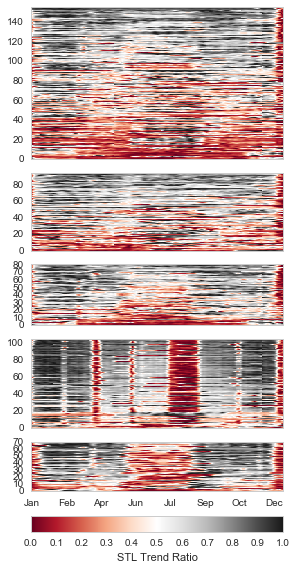

In [34]:
plotmap_subplots(temp_trend_generalized_sorted, meta, 'RdGy', "STL Trend Ratio",
                 " ", "", " ", " ", 0, 1)
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/stl_trend_heatmap.pdf"));

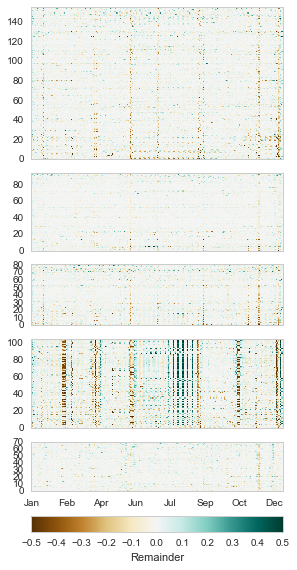

In [33]:
plotmap_subplots(temp_remainder_generalized_sorted, meta, 'BrBG', "Remainder",
                 " ", "", " ", " ", -0.5, 0.5)
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/stl_remainder_heatmap.pdf"));

In [47]:
temp_trend.to_csv(os.path.join(repos_path,"data/interim/temp_stl_trend.csv"))
temp_remainder.to_csv(os.path.join(repos_path,"data/interim/temp_stl_remainder.csv"))
temp_seasonal.to_csv(os.path.join(repos_path,"data/processed/features_stl_weeklypattern.csv"))